<a href="https://colab.research.google.com/github/benny-png/CODEDEX-HACKATHON-PARIS_OLYMPICS_PREDICTION-Team-Hackathletes/blob/main/Swimming_model_Hackathon_codedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install researchpy

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SARIMAX
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import researchpy as rp
from scipy.stats import chi2_contingency, pointbiserialr, pearsonr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
#extracting Paris dataset zip file and saving to datasets folder
import zipfile
zip_ref = zipfile.ZipFile("/content/Olympic_Swimming_Results_1912to2020.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/datasets")
zip_ref.close()


In [ ]:
# Load the dataset SOURCE https://www.kaggle.com/datasets/datasciencedonut/olympic-swimming-1912-to-2020
# df = pd.read_csv('/content/drive/MyDrive/datasets/Olympic_Swimming_Results_1912to2020.csv')
df = pd.read_csv('/content/Olympic_Swimming_Results_1912to2020.csv')

In [ ]:
df.columns
df.shape

(4359, 10)

In [ ]:
# Filter data for men's 100m freestyle
event_data = df[(df['Distance (in meters)'] == '100m') &
                (df['Stroke'] == 'Freestyle') &
                (df['Gender'] == 'Men')]

In [ ]:
event_data.head()

,Location,Year,Distance (in meters),Stroke,Relay?,Gender,Team,Athlete,Results,Rank
24,Tokyo,2020,100m,Freestyle,0,Men,USA,Caeleb Dressel,47.02,1
25,Tokyo,2020,100m,Freestyle,0,Men,AUS,Kyle Chalmers,47.08,2
26,Tokyo,2020,100m,Freestyle,0,Men,ROC,Kliment Kolesnikov,47.44,3
27,Tokyo,2020,100m,Freestyle,0,Men,FRA,Maxime Grousset,47.72,4
28,Tokyo,2020,100m,Freestyle,0,Men,KOR,Sunwoo Hwang,47.82,4


In [ ]:
# Convert 'Results' to numeric values, handle 'Did not finish' and 'Did not start'
def convert_time(result):
    try:
        return float(result)
    except:
        # Return NaN for 'Did not finish' and 'Did not start'
        return np.nan

In [ ]:
event_data['Results'] = event_data['Results'].apply(convert_time)

<ipython-input-9-ce729cbeef2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data['Results'] = event_data['Results'].apply(convert_time)


In [ ]:
# Drop rows with NaN values in 'Results'
event_data = event_data.dropna(subset=['Results'])
event_data.head()

,Location,Year,Distance (in meters),Stroke,Relay?,Gender,Team,Athlete,Results,Rank
24,Tokyo,2020,100m,Freestyle,0,Men,USA,Caeleb Dressel,47.02,1
25,Tokyo,2020,100m,Freestyle,0,Men,AUS,Kyle Chalmers,47.08,2
26,Tokyo,2020,100m,Freestyle,0,Men,ROC,Kliment Kolesnikov,47.44,3
27,Tokyo,2020,100m,Freestyle,0,Men,FRA,Maxime Grousset,47.72,4
28,Tokyo,2020,100m,Freestyle,0,Men,KOR,Sunwoo Hwang,47.82,4


In [ ]:
# Define a function to calculate Cramér's V for categorical-categorical correlation
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

In [ ]:
# Initialize the correlation matrix
correlation_matrix = pd.DataFrame(index=event_data.columns, columns=event_data.columns)

In [ ]:
for col1 in event_data.columns:
    for col2 in event_data.columns:
        if event_data[col1].dtype == 'object' and event_data[col2].dtype == 'object':
            correlation_matrix.loc[col1, col2] = cramers_v(event_data[col1], event_data[col2])
        elif event_data[col1].dtype != 'object' and event_data[col2].dtype != 'object':
            correlation_matrix.loc[col1, col2] = pearsonr(event_data[col1], event_data[col2])[0]
        else:
            if event_data[col1].dtype == 'object':
                # Calculate point biserial correlation for each dummy column and take the average
                dummy_cols = pd.get_dummies(event_data[col1], drop_first=True)
                correlations = [pointbiserialr(dummy_cols[col], event_data[col2])[0] for col in dummy_cols.columns]
                correlation_matrix.loc[col1, col2] = np.mean(correlations)
            else:
                # Calculate point biserial correlation for each dummy column and take the average
                dummy_cols = pd.get_dummies(event_data[col2], drop_first=True)
                correlations = [pointbiserialr(event_data[col1], dummy_cols[col])[0] for col in dummy_cols.columns]
                correlation_matrix.loc[col1, col2] = np.mean(correlations)

In [ ]:
# Convert correlation matrix to numeric
correlation_matrix = correlation_matrix.astype(float)

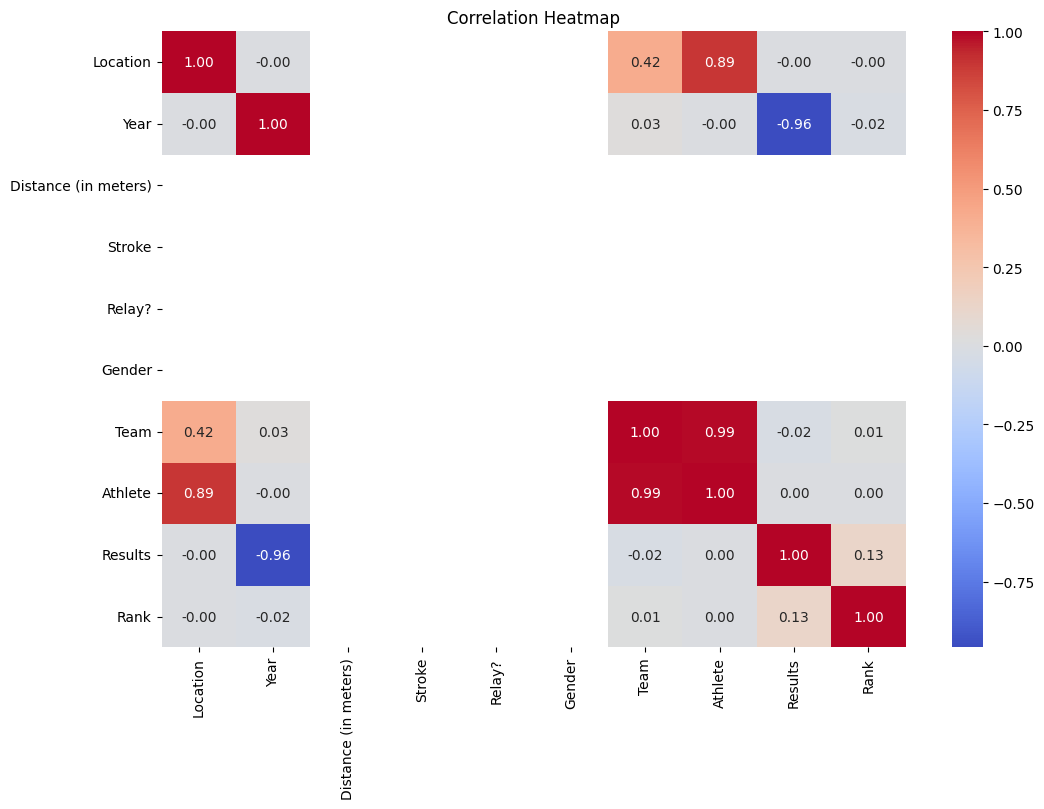

In [ ]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert 'Results' to numeric values, handle 'Did not finish' and 'Did not start'
def convert_time(result):
    try:
        return float(result)
    except:
        # Return NaN for 'Did not finish' and 'Did not start'
        return np.nan


# Drop rows with NaN values in 'Results'
df['Results'] = df['Results'].apply(convert_time)
df = df.dropna(subset=['Results'])

# Add a new column for decade to avoid overlapping (TOO MANY DATA POINTS TO VISUALIZE)

df['Decade'] = (df['Year'] // 10) * 10

<ipython-input-20-93434ad923a7>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Decade'] = (df['Year'] // 10) * 10


In [ ]:
# Filter data for each stroke type
freestyle_data = df[df['Stroke'] == 'Freestyle']
backstroke_data = df[df['Stroke'] == 'Backstroke']
butterfly_data = df[df['Stroke'] == 'Butterfly']
breaststroke_data = df[df['Stroke'] == 'Breaststroke']

In [ ]:
# Function to create aggregated plots
def create_aggregated_plots(data, stroke_name):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{stroke_name} Performance Over Decades', fontsize=16)

    # Aggregate data by decade
    agg_data = data.groupby('Decade').agg({'Results': ['mean', 'std', 'count']}).reset_index()
    agg_data.columns = ['Decade', 'Average Time (s)', 'Standard Deviation (s)', 'Number of Competitors']

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Decade', y='Results', data=data)
    plt.title('Box Plot of Times per Decade')
    plt.xlabel('Decade')
    plt.ylabel('Time (seconds)')

    # Linear plot
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Decade', y='Average Time (s)', data=agg_data, marker='o')
    plt.fill_between(agg_data['Decade'],
                     agg_data['Average Time (s)'] - agg_data['Standard Deviation (s)'],
                     agg_data['Average Time (s)'] + agg_data['Standard Deviation (s)'], alpha=0.2)
    plt.title('Trend of Average Times per Decade')
    plt.xlabel('Decade')
    plt.ylabel('Average Time (seconds)')

    # # Violin plot
    # plt.subplot(1, 3, 3)
    # sns.violinplot(x='Decade', y='Results', data=data, inner="quartile")
    # plt.title('Violin Plot of Times per Decade')
    # plt.xlabel('Decade')
    # plt.ylabel('Time (seconds)')


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

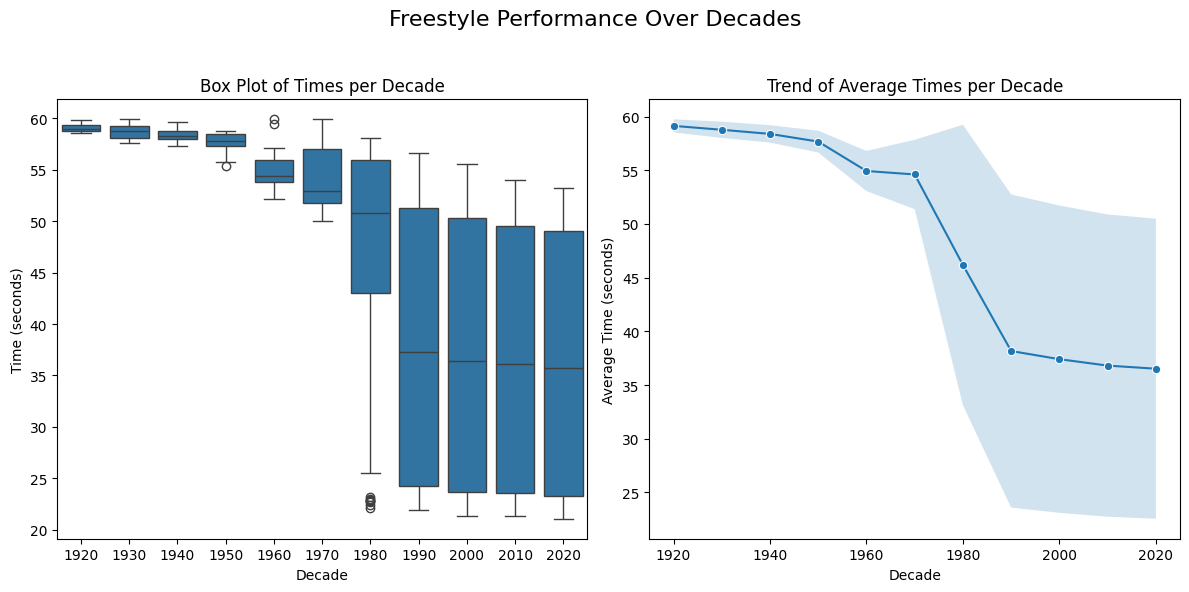

In [ ]:
# Create aggregated plots for each stroke type
create_aggregated_plots(freestyle_data, 'Freestyle')

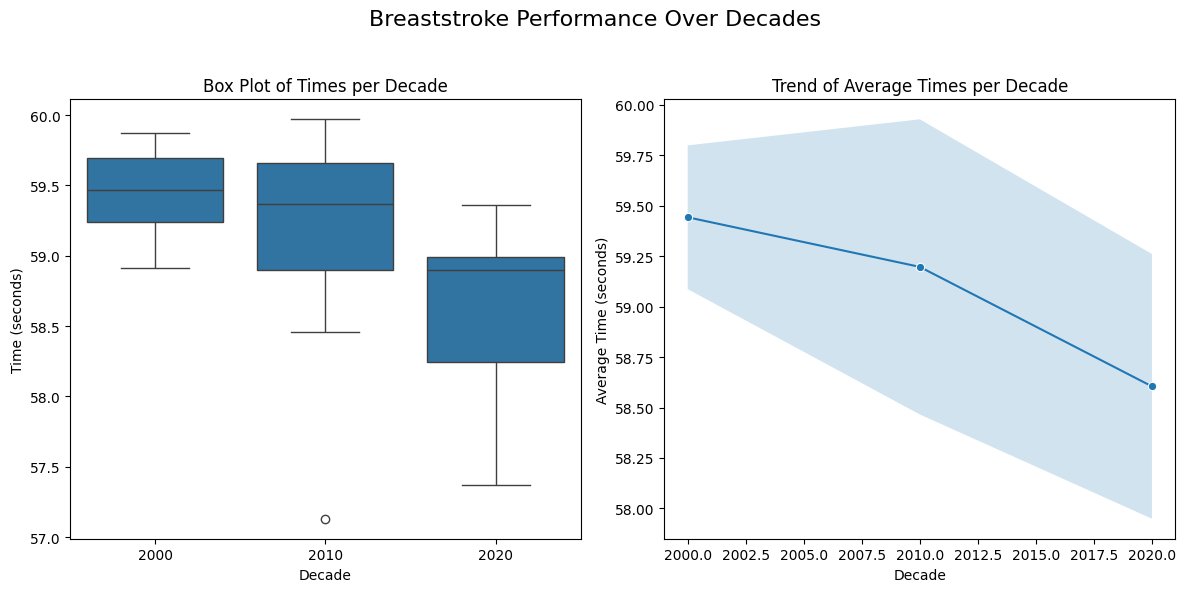

In [ ]:
create_aggregated_plots(breaststroke_data, 'Breaststroke')

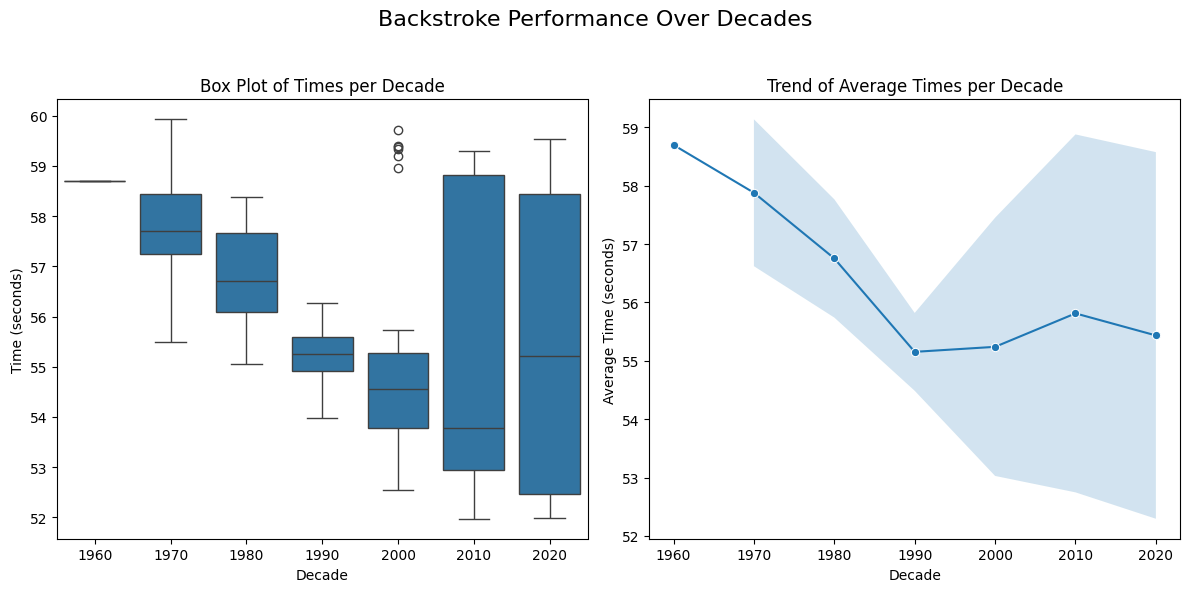

In [ ]:
create_aggregated_plots(backstroke_data, 'Backstroke')

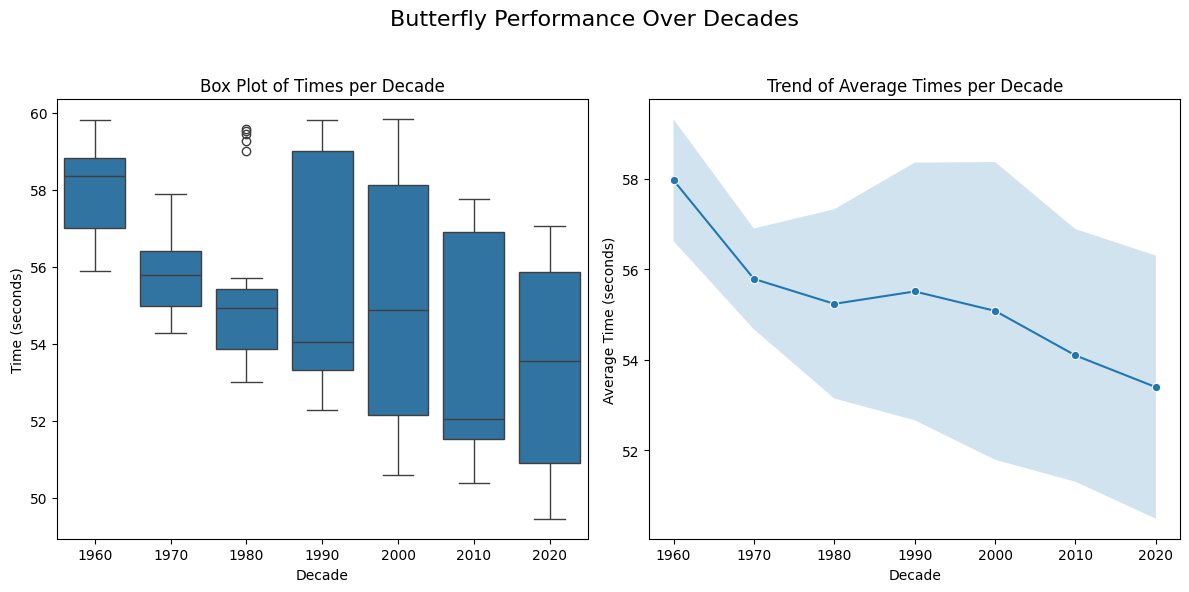

In [ ]:
create_aggregated_plots(butterfly_data, 'Butterfly')


In [ ]:
#trend shows that over the past DECADES the average time for swimming competitions has been decreasing

#that is athletes keep improving significantly by shortening time taken to swim

#this is a notable important analysis

In [ ]:
# # Convert 'Distance (in meters)' to numeric if it still exists in your full dataset
# # If the dataset contains other distances or requires such conversion
# if 'Distance (in meters)' in event_data.columns:
#     event_data['Distance (in meters)'] = event_data['Distance (in meters)'].apply(lambda x: int(x.replace('m', '')) if isinstance(x, str) else x)

In [ ]:
# event_data['Distance (in meters)']
event_data['Distance (in meters)'] = event_data['Distance (in meters)'].str.extract(r'(\d+)').astype(float)
event_data['Relay?'] = pd.to_numeric(event_data['Relay?'], errors='coerce')

In [ ]:
event_data = event_data.drop(columns='Athlete')
# event_data = event_data.drop(columns='Location')

In [ ]:
event_data = pd.get_dummies(event_data, columns=['Location', 'Stroke', 'Gender', 'Team'])
event_data.head()

,Year,Distance (in meters),Relay?,Results,Rank,Location_Amsterdam,Location_Angeles,Location_Athens,Location_Atlanta,Location_Barcelona,...,Team_ROC,Team_ROU,Team_RSA,Team_RUS,Team_SUI,Team_SWE,Team_UKR,Team_URS,Team_USA,Team_VEN
24,2020,100.0,0,47.02,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
25,2020,100.0,0,47.08,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26,2020,100.0,0,47.44,3,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
27,2020,100.0,0,47.72,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28,2020,100.0,0,47.82,4,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
event_data['Year'].dtype

dtype('int64')

In [ ]:
# Select features and target
X = event_data.drop(columns='Results')  # Add more features if needed
X.to_csv('/content/input_data.csv', index=False)
y = event_data['Results']

In [ ]:
X

,Year,Distance (in meters),Relay?,Rank,Location_Amsterdam,Location_Angeles,Location_Athens,Location_Atlanta,Location_Barcelona,Location_Beijing,...,Team_ROC,Team_ROU,Team_RSA,Team_RUS,Team_SUI,Team_SWE,Team_UKR,Team_URS,Team_USA,Team_VEN
24,2020,100.0,0,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
25,2020,100.0,0,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26,2020,100.0,0,3,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
27,2020,100.0,0,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28,2020,100.0,0,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,1932,100.0,0,4,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4020,1932,100.0,0,4,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4091,1928,100.0,0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4092,1928,100.0,0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X.columns

Index(['Year', 'Distance (in meters)', 'Relay?', 'Rank', 'Location_Amsterdam',
       'Location_Angeles', 'Location_Athens', 'Location_Atlanta',
       'Location_Barcelona', 'Location_Beijing', 'Location_Berlin',
       'Location_City', 'Location_Helsinki', 'Location_London',
       'Location_Melbourne', 'Location_Montreal', 'Location_Moscow',
       'Location_Munich', 'Location_Paris', 'Location_Rio', 'Location_Rome',
       'Location_Seoul', 'Location_Sydney', 'Location_Tokyo',
       'Stroke_Freestyle', 'Gender_Men', 'Team_ALG', 'Team_ARG', 'Team_AUS',
       'Team_BEL', 'Team_BRA', 'Team_CAN', 'Team_CRO', 'Team_CUB', 'Team_EUN',
       'Team_FRA', 'Team_FRG', 'Team_GBR', 'Team_GDR', 'Team_GER', 'Team_HUN',
       'Team_ITA', 'Team_JPN', 'Team_KOR', 'Team_NED', 'Team_PUR', 'Team_ROC',
       'Team_ROU', 'Team_RSA', 'Team_RUS', 'Team_SUI', 'Team_SWE', 'Team_UKR',
       'Team_URS', 'Team_USA', 'Team_VEN'],
      dtype='object')

In [ ]:
y

24      47.02
25      47.08
26      47.44
27      47.72
28      47.82
        ...  
4019    59.20
4020    59.50
4091    58.60
4092    59.80
4174    59.00
Name: Results, Length: 167, dtype: float64

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predict winning times
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([52.67081616, 53.96587019, 51.36240646, 49.03019802, 52.2642155 ,
       47.97888427, 52.97740488, 51.51962281, 52.58341451, 53.96587019,
       48.81436408, 48.77992593, 48.07469258, 50.17479575, 47.01491012,
       48.38134852, 57.2158666 , 49.58436863, 58.42269837, 47.4306506 ,
       51.36240646, 48.12080938, 47.66962696, 47.57847248, 57.2158666 ,
       51.20557758, 57.2159204 , 49.72417129, 49.84045524, 58.03349437,
       48.08341089, 58.44833266, 55.39064911, 58.19740586])

In [ ]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Predicted winning times:", y_pred)

Mean Squared Error: 0.14337334783858943
Predicted winning times: [52.67081616 53.96587019 51.36240646 49.03019802 52.2642155  47.97888427
 52.97740488 51.51962281 52.58341451 53.96587019 48.81436408 48.77992593
 48.07469258 50.17479575 47.01491012 48.38134852 57.2158666  49.58436863
 58.42269837 47.4306506  51.36240646 48.12080938 47.66962696 47.57847248
 57.2158666  51.20557758 57.2159204  49.72417129 49.84045524 58.03349437
 48.08341089 58.44833266 55.39064911 58.19740586]


In [ ]:
import joblib
# Save the trained model
joblib.dump(model, '/content/drive/MyDrive/output_model/swimming_time_taken_predictor.joblib')

['/content/drive/MyDrive/output_model/swimming_time_taken_predictor.joblib']